In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def generate_top_techniques_heatmap(unique_techniques_per_group, id_to_name_map, top_n):
    """
    Generates a co-occurrence matrix and heatmap for the top N most frequent techniques across APT groups.

    Args:
        unique_techniques_per_group (dict): Dictionary with APT group names as keys
                                             and list of techniques (ID, name) as values.
        id_to_name_map (dict): Mapping of technique IDs to technique names.
        top_n (int): The number of top techniques to display based on frequency across APT groups.
    """
    # Extract all techniques from unique_techniques_per_group
    all_techniques = [tech for techniques in unique_techniques_per_group.values() for tech in techniques]
    
    # Count frequency of each technique ID
    technique_counts = Counter([tech[0] for tech in all_techniques])
    
    # Get the top N techniques by frequency
    top_techniques = [tech for tech, count in technique_counts.most_common(top_n)]
    
    # Create a DataFrame for the co-occurrence matrix
    matrix = pd.DataFrame(0, index=unique_techniques_per_group.keys(), columns=top_techniques)

    # Fill the matrix: 1 if the APT group uses the technique, otherwise 0
    for group, techniques in unique_techniques_per_group.items():
        for tech in techniques:
            tech_id = tech[0]  # Extract the technique ID
            if tech_id in top_techniques:
                matrix.loc[group, tech_id] = 1

    # Create a co-occurrence matrix for the top N techniques
    co_occurrence_matrix = np.dot(matrix.T, matrix)

    # Create a list of labels for the heatmap (ID - Name)
    top_technique_labels = [f"{tech} - {id_to_name_map[tech]}" for tech in top_techniques if tech in id_to_name_map]

    # Improved Plot
    plt.figure(figsize=(14, 10))  # Adjust figure size for better visibility in LaTeX
    sns.heatmap(co_occurrence_matrix, cmap='cividis', annot=True, fmt="d",
                xticklabels=top_technique_labels, yticklabels=top_technique_labels, 
                linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Co-occurrence Count'})

    #plt.title(f"Heatmap of Top {top_n} Techniques Co-occurrence Across APT Groups", fontsize=18)
    
    # Improve label readability
    plt.xticks(rotation=90, fontsize=8, ha="center")  # Rotate and center-align x-axis labels
    plt.yticks(rotation=0, fontsize=8)   # Keep y-axis labels horizontal
    plt.tight_layout()  # Adjust layout to prevent cutoff labels

    # Save the figure as a high-quality PDF for LaTeX
    plt.savefig("heatmap_top_techniques.pdf", format='pdf', bbox_inches='tight')

    # Show plot
    plt.show()


In [136]:
import pandas as pd

def analyze_techniques(csv_file):
    """
    Analyzes the techniques used per Source ID (group), finds the most common techniques,
    and identifies techniques that are unique to each group.
    
    Args:
        csv_file (str): The path to the CSV file.
    
    Returns:
        tuple: 
            - A dictionary of unique techniques per Source ID.
            - A DataFrame of the most common techniques.
            - A dictionary of techniques that are only used by one group (unique per group).
    """
    # Load the 'techniques used' sheet
    df = pd.read_excel(csv_file, sheet_name='techniques used')

    # Extract relevant columns: 'source ID', 'source name', 'target ID', and 'target name'
    data = df[['source ID', 'source name', 'target ID', 'target name', 'mapping description']]
    
    # 1. Create a mapping between target ID and target name
    id_to_name_map = dict(zip(data['target ID'], data['target name']))
    
    # 2. Unique Techniques per Source name (Group) including both target ID and target name
    unique_techniques_per_group = data.groupby('source name').apply(
        lambda x: [(tid, id_to_name_map[tid]) for tid in x['target ID'].unique()] ).to_dict()


    # 2. Count Occurrences of Each Technique (target ID) across all groups
    technique_counts = data['target ID'].value_counts().reset_index()
    technique_counts.columns = ['target ID', 'count']

    # Join the counts with the 'target name' for readability
    most_common_techniques = technique_counts.merge(data[['target ID', 'target name']].drop_duplicates(), on='target ID')
    # 4. Techniques unique to a single group (used by only one group)
    unique_techniques_per_group_only = {}
    
     # Filter out techniques used by only one group
    techniques_used_once = technique_counts[technique_counts['count'] == 1]['target ID'].tolist()
        
    # Iterate through groups and find techniques that are used by only one group
    for group, techniques in unique_techniques_per_group.items():
        unique_to_group = [tech for tech in techniques if tech[0] in techniques_used_once]  # tech[0] is target ID
        unique_techniques_per_group_only[group] = unique_to_group
    
    return unique_techniques_per_group, most_common_techniques, unique_techniques_per_group_only

# Example usage:
csv_file = r"C:\Users\Aakanksha Saha\Downloads\enterprise-attack-v15.1-groups.xlsx"
unique_techniques_per_group, most_common_techniques, unique_techniques_per_group_only = analyze_techniques(csv_file)




C:\Users\Aakanksha Saha\AppData\Local\Temp\ipykernel_15364\1085171600.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_techniques_per_group = data.groupby('source name').apply(


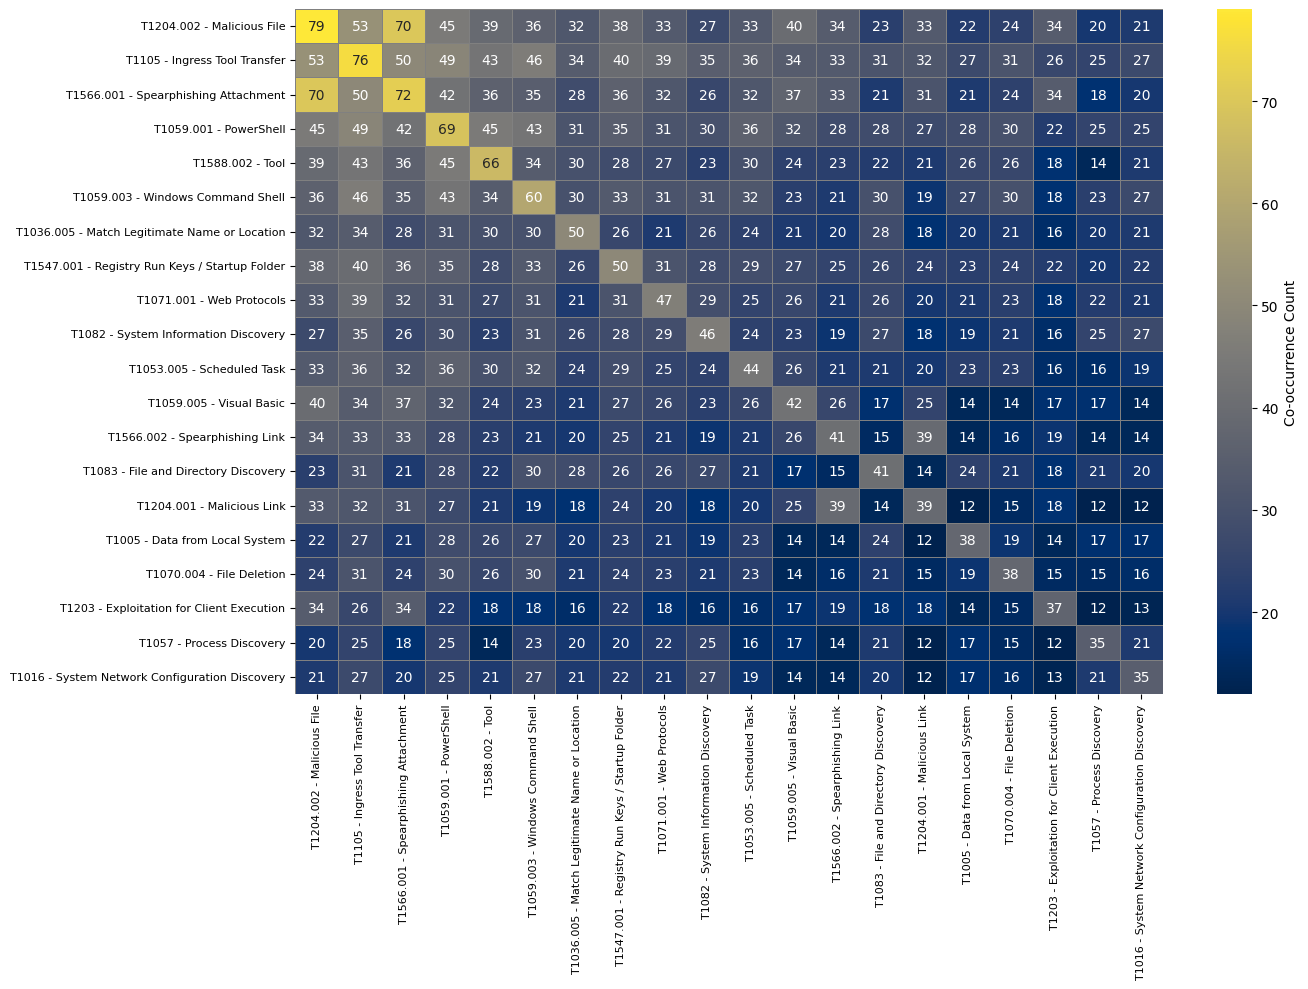

In [137]:
# Create a mapping for target IDs to target names
id_to_name_map = {tech[0]: tech[1] for techniques in unique_techniques_per_group.values() for tech in techniques}
generate_top_techniques_heatmap(unique_techniques_per_group, id_to_name_map, top_n=20)

In [116]:
# Print results

#print("\nUnique Techniques per Group (Source Name):")
#for group, techniques in unique_techniques_per_group.items():
#    print(f"{group}: {techniques}")

print("\nMost Common Techniques Across All Groups:")
print(most_common_techniques.head(20))



Most Common Techniques Across All Groups:
    target ID  count                             target name
0   T1204.002     79                          Malicious File
1       T1105     76                   Ingress Tool Transfer
2   T1566.001     72                Spearphishing Attachment
3   T1059.001     69                              PowerShell
4   T1588.002     66                                    Tool
5   T1059.003     60                   Windows Command Shell
6   T1036.005     50       Match Legitimate Name or Location
7   T1547.001     50      Registry Run Keys / Startup Folder
8   T1071.001     47                           Web Protocols
9       T1082     46            System Information Discovery
10  T1053.005     44                          Scheduled Task
11  T1059.005     42                            Visual Basic
12  T1566.002     41                      Spearphishing Link
13      T1083     41            File and Directory Discovery
14  T1204.001     39                      

In [117]:
print("\nTechniques Unique to Each Group (Only Used by One Group):")
for group, techniques in unique_techniques_per_group_only.items():
    print(f"{group}: {techniques}")


Techniques Unique to Each Group (Only Used by One Group):
APT-C-36: []
APT1: []
APT12: [('T1568.003', 'DNS Calculation')]
APT16: []
APT17: []
APT18: []
APT19: []
APT28: [('T1550.001', 'Application Access Token'), ('T1092', 'Communication Through Removable Media'), ('T1546.015', 'Component Object Model Hijacking'), ('T1048.002', 'Exfiltration Over Asymmetric Encrypted Non-C2 Protocol'), ('T1211', 'Exploitation for Defense Evasion'), ('T1001.001', 'Junk Data'), ('T1498', 'Network Denial of Service'), ('T1137.002', 'Office Test')]
APT29: [('T1087.004', 'Cloud Account'), ('T1586.003', 'Cloud Accounts'), ('T1651', 'Cloud Administration Command'), ('T1098.005', 'Device Registration'), ('T1562.008', 'Disable or Modify Cloud Logs'), ('T1090.004', 'Domain Fronting'), ('T1027.006', 'HTML Smuggling'), ('T1665', 'Hide Infrastructure'), ('T1556.007', 'Hybrid Identity'), ('T1037.004', 'RC Scripts'), ('T1649', 'Steal or Forge Authentication Certificates')]
APT3: []
APT30: []
APT32: [('T1552.002', 'C

In [49]:
csv_file = r"C:\Users\Aakanksha Saha\Downloads\enterprise-attack-v15.1-groups.xlsx"

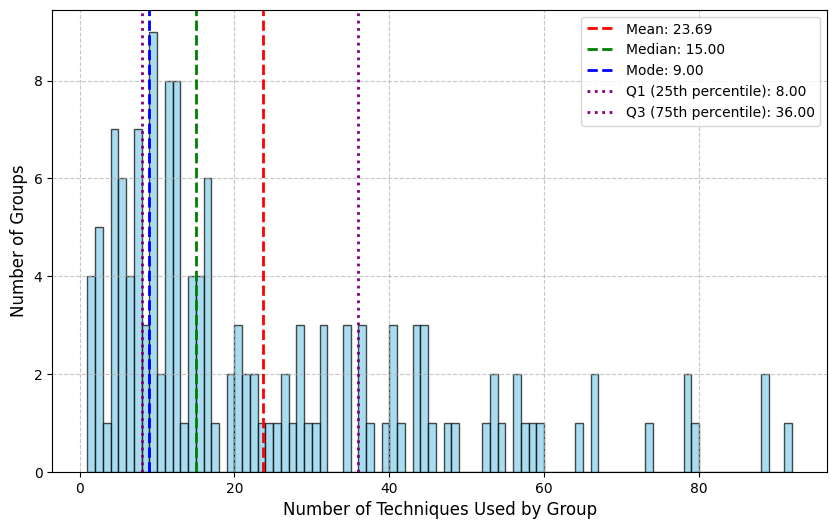


Mean number of techniques used per group: 23.685314685314687
Median number of techniques used per group: 15.0
Standard deviation of techniques per group: 21.325254346986252
Minimum number of techniques used by any group: 1
Maximum number of techniques used by any group: 91
Quartiles (25th, 50th, 75th percentiles):
0.25     8.0
0.50    15.0
0.75    36.0
dtype: float64
Most common number of techniques used by groups (mode): 9


In [134]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_techniques(csv_file):
    """
    Analyzes the techniques used per Source ID (group), finds the most common techniques,
    identifies techniques that are unique to each group, and calculates statistics (mean, median, 
    standard deviation, quartiles) for the number of techniques used per group.
    
    Args:
        csv_file (str): The path to the CSV file.
    
    Returns:
        tuple: 
            - A dictionary of unique techniques per Source ID.
            - A DataFrame of the most common techniques.
            - A dictionary of techniques that are only used by one group (unique per group).
            - Various statistics (mean, median, standard deviation, quartiles).
    """
    # Load the 'techniques used' sheet
    df = pd.read_excel(csv_file, sheet_name='techniques used')

    # Extract relevant columns: 'source ID', 'source name', 'target ID', and 'target name'
    data = df[['source ID', 'source name', 'target ID', 'target name', 'mapping description']]

    # 1. Unique Techniques per Source ID (Group)
    unique_techniques_per_group = data.groupby('source name')['target ID'].unique().to_dict()

    # 2. Count Occurrences of Each Technique (target ID) across all groups
    technique_counts = data['target ID'].value_counts().reset_index()
    technique_counts.columns = ['target ID', 'count']

    # Join the counts with the 'target name' for readability
    most_common_techniques = technique_counts.merge(data[['target ID', 'target name']].drop_duplicates(), on='target ID')

    # 3. Techniques unique to a single group (used by only one group)
    unique_techniques_per_group_only = {}
    
    # Filter out techniques used by only one group
    techniques_used_once = technique_counts[technique_counts['count'] == 1]['target ID'].tolist()
    
    # Iterate through groups and find techniques that are used by only one group
    for group, techniques in unique_techniques_per_group.items():
        unique_to_group = [tech for tech in techniques if tech in techniques_used_once]
        unique_techniques_per_group_only[group] = unique_to_group

    # 4. Calculate statistics (mean, median, std, quartiles) of techniques per group
    techniques_per_group = [len(techniques) for techniques in unique_techniques_per_group.values()]
    techniques_series = pd.Series(techniques_per_group)
    
    mean_techniques_per_group = techniques_series.mean()
    median_techniques_per_group = techniques_series.median()
    std_techniques_per_group = techniques_series.std()
    min_techniques_per_group = techniques_series.min()
    max_techniques_per_group = techniques_series.max()
    quartiles = techniques_series.quantile([0.25, 0.5, 0.75])
    mode_techniques_per_group = techniques_series.mode()[0]

    # Create histogram with more visually appealing styles
    plt.figure(figsize=(10, 6))
    plt.hist(techniques_series, bins=range(min_techniques_per_group, max_techniques_per_group + 2), 
             edgecolor='black', color='skyblue', alpha=0.7)

    # Add lines for mean, median, mode, and quartiles
    plt.axvline(mean_techniques_per_group, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_techniques_per_group:.2f}')
    plt.axvline(median_techniques_per_group, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_techniques_per_group:.2f}')
    plt.axvline(mode_techniques_per_group, color='blue', linestyle='dashed', linewidth=2, label=f'Mode: {mode_techniques_per_group:.2f}')
    plt.axvline(quartiles[0.25], color='purple', linestyle='dotted', linewidth=2, label=f'Q1 (25th percentile): {quartiles[0.25]:.2f}')
    plt.axvline(quartiles[0.75], color='purple', linestyle='dotted', linewidth=2, label=f'Q3 (75th percentile): {quartiles[0.75]:.2f}')

    # Titles and labels
    #plt.title('Distribution of Techniques Count Across Groups', fontsize=16)
    plt.xlabel('Number of Techniques Used by Group', fontsize=12)
    plt.ylabel('Number of Groups', fontsize=12)

    # Grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Save the figure as a PDF
    plt.savefig('technique_distribution.pdf', format='pdf', bbox_inches='tight')

    # Show plot (optional, not needed for LaTeX but helpful for viewing)
    plt.show()

    return (unique_techniques_per_group, most_common_techniques, 
            unique_techniques_per_group_only, 
            mean_techniques_per_group, median_techniques_per_group, 
            std_techniques_per_group, min_techniques_per_group, 
            max_techniques_per_group, quartiles, mode_techniques_per_group)

# Example usage:
csv_file = r"C:\Users\Aakanksha Saha\Downloads\enterprise-attack-v15.1-groups.xlsx"
(unique_techniques_per_group, most_common_techniques, unique_techniques_per_group_only, 
 mean_techniques_per_group, median_techniques_per_group, 
 std_techniques_per_group, min_techniques_per_group, 
 max_techniques_per_group, quartiles, mode_techniques_per_group) = analyze_techniques(csv_file)

# Print the unique techniques per group
#print("Unique Techniques per Group (Source ID):")
#for group, techniques in unique_techniques_per_group.items():
#    count = len(techniques)
#    print(f"{group}: {techniques} (Count: {count})")

# Print the most common techniques across all groups
#print("\nMost Common Techniques Across All Groups:")
#print(most_common_techniques.head(20))  # Show top 10 most common techniques

#empty_count = 0
# Print techniques that are unique to each group
#print("\nTechniques Unique to Each Group (Only Used by One Group):")
#for group, techniques in unique_techniques_per_group_only.items():
#    print(f"{group}: {techniques}")  
#    if not techniques:  # If the list is empty
#        empty_count += 1

#print(f"\nTotal number of groups with empty techniques list: {empty_count}")

# Print statistical summary of techniques used by groups
print(f"\nMean number of techniques used per group: {mean_techniques_per_group}")
print(f"Median number of techniques used per group: {median_techniques_per_group}")
print(f"Standard deviation of techniques per group: {std_techniques_per_group}")
print(f"Minimum number of techniques used by any group: {min_techniques_per_group}")
print(f"Maximum number of techniques used by any group: {max_techniques_per_group}")
print(f"Quartiles (25th, 50th, 75th percentiles):\n{quartiles}")
print(f"Most common number of techniques used by groups (mode): {mode_techniques_per_group}")



Statistics of Unique Techniques Used per Group:
Mean number of unique techniques per group: 0.8741258741258742
Median number of unique techniques per group: 0.0
Standard deviation of unique techniques per group: 1.8495036748271292
Minimum number of unique techniques used by any group: 0
Maximum number of unique techniques used by any group: 11
Quartiles (25th, 50th, 75th percentiles):
0.25    0.0
0.50    0.0
0.75    1.0
dtype: float64
Most common number of unique techniques used by groups (mode): 0


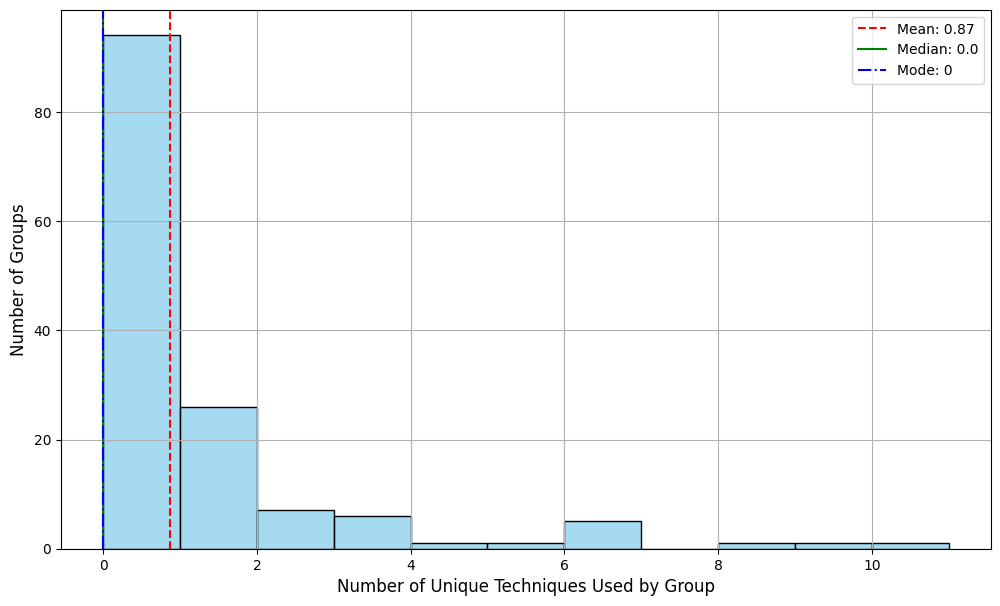

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_techniques(csv_file):
    """
    Analyzes the techniques used per Source ID (group), finds the most common techniques,
    identifies techniques that are unique to each group, and calculates statistics for the 
    number of unique techniques used per group.
    
    Args:
        csv_file (str): The path to the CSV file.
    
    Returns:
        tuple: 
            - A dictionary of unique techniques per Source ID.
            - A DataFrame of the most common techniques.
            - A dictionary of techniques that are only used by one group (unique per group).
            - Various statistics for unique techniques (mean, median, std, min, max, quartiles).
            - List of counts of unique techniques per group.
    """
    # Load the 'techniques used' sheet
    df = pd.read_excel(csv_file, sheet_name='techniques used')

    # Extract relevant columns: 'source ID', 'source name', 'target ID', and 'target name'
    data = df[['source ID', 'source name', 'target ID', 'target name', 'mapping description']]

    # 1. Unique Techniques per Source ID (Group)
    unique_techniques_per_group = data.groupby('source name')['target ID'].unique().to_dict()

    # 2. Count Occurrences of Each Technique (target ID) across all groups
    technique_counts = data['target ID'].value_counts().reset_index()
    technique_counts.columns = ['target ID', 'count']

    # Join the counts with the 'target name' for readability
    most_common_techniques = technique_counts.merge(data[['target ID', 'target name']].drop_duplicates(), on='target ID')

    # 3. Techniques unique to a single group (used by only one group)
    unique_techniques_per_group_only = {}
    
    # Filter out techniques used by only one group
    techniques_used_once = technique_counts[technique_counts['count'] == 1]['target ID'].tolist()
    
    # Iterate through groups and find techniques that are used by only one group
    for group, techniques in unique_techniques_per_group.items():
        unique_to_group = [tech for tech in techniques if tech in techniques_used_once]
        unique_techniques_per_group_only[group] = unique_to_group

    # 4. Calculate statistics for unique techniques per group
    unique_techniques_counts = [len(techniques) for techniques in unique_techniques_per_group_only.values()]
    
    if unique_techniques_counts:
        mean_unique = pd.Series(unique_techniques_counts).mean()
        median_unique = pd.Series(unique_techniques_counts).median()
        std_unique = pd.Series(unique_techniques_counts).std()
        min_unique = pd.Series(unique_techniques_counts).min()
        max_unique = pd.Series(unique_techniques_counts).max()
        quartiles_unique = pd.Series(unique_techniques_counts).quantile([0.25, 0.5, 0.75])
        mode_unique = pd.Series(unique_techniques_counts).mode()[0] if pd.Series(unique_techniques_counts).mode().size > 0 else None
    else:
        mean_unique = median_unique = std_unique = min_unique = max_unique = mode_unique = 0
        quartiles_unique = [0, 0, 0]

    return (unique_techniques_per_group, most_common_techniques, 
            unique_techniques_per_group_only, mean_unique, median_unique, 
            std_unique, min_unique, max_unique, quartiles_unique, mode_unique,
            unique_techniques_counts)

# Example usage:
csv_file = r"C:\Users\Aakanksha Saha\Downloads\enterprise-attack-v15.1-groups.xlsx"
(unique_techniques_per_group, most_common_techniques, unique_techniques_per_group_only, 
 mean_unique, median_unique, std_unique, min_unique, max_unique, 
 quartiles_unique, mode_unique, unique_techniques_counts) = analyze_techniques(csv_file)


# Print statistical summary of unique techniques used by groups
print(f"\nStatistics of Unique Techniques Used per Group:")
print(f"Mean number of unique techniques per group: {mean_unique}")
print(f"Median number of unique techniques per group: {median_unique}")
print(f"Standard deviation of unique techniques per group: {std_unique}")
print(f"Minimum number of unique techniques used by any group: {min_unique}")
print(f"Maximum number of unique techniques used by any group: {max_unique}")
print(f"Quartiles (25th, 50th, 75th percentiles):\n{quartiles_unique}")
print(f"Most common number of unique techniques used by groups (mode): {mode_unique}")

# Visualize distribution of unique techniques per group
plt.figure(figsize=(12, 7))


#Plot histogram
sns.histplot(unique_techniques_counts, bins=range(min(unique_techniques_counts), max(unique_techniques_counts) + 1),
                 color='skyblue', edgecolor='black', linewidth=1)

# Add titles and labels
#plt.title('Distribution of Unique Techniques Count Across APT Groups', fontsize=16)
plt.xlabel('Number of Unique Techniques Used by Group', fontsize=12)
plt.ylabel('Number of Groups', fontsize=12)

# Annotate key statistics (mean, median, mode)
plt.axvline(mean_unique, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_unique:.2f}')
plt.axvline(median_unique, color='green', linestyle='-', linewidth=1.5, label=f'Median: {median_unique}')
plt.axvline(mode_unique, color='blue', linestyle='-.', linewidth=1.5, label=f'Mode: {mode_unique}')

# Display legend with key statistics
plt.legend()

# Enable grid for better readability
plt.grid(True)

# Save the figure as a PDF
plt.savefig('unique_techniques_distribution.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

# Print techniques that are unique to each group
#print("\nTechniques Unique to Each Group (Only Used by One Group):")
#empty_count = 0
#for group, techniques in unique_techniques_per_group_only.items():
#    print(f"{group}: {techniques}")  
#    if not techniques:  # If the list is empty
#        empty_count += 1

#print(f"\nTotal number of groups with empty unique techniques list: {empty_count}")

